#Installing Libraries

In [ ]:
!pip install torch torchvision --quiet

In [ ]:
!pip install timm --quiet
!pip install scikit-image --quiet
!pip install opencv-python-headless --quiet
!pip install natsort --quiet # You used this before for file sorting
!pip install tqdm --quiet # Often pre-installed, but good to include
!pip install seaborn --quiet # Often pre-installed, but good to include

#Loading the Pre-Trained Model

In [ ]:
# Import necessary libraries
import torch
import timm

# 1. Choose a ViT Variant
# Options similar to SAM backbones (Base, Large, Huge):
# 'vit_base_patch16_224' (ViT-B/16) - Similar to SAM-B, ~86M params
# 'vit_large_patch16_224' (ViT-L/16) - Similar to SAM-L, ~304M params
# 'vit_huge_patch14_224' (ViT-H/14) - Similar to SAM-H, ~632M params
# Note: SAM originally used MAE pre-training. Timm's pretrained=True usually loads ImageNet weights,
# which are still a very strong starting point for transfer learning.
# Loading specific SAM checkpoint weights might require manual steps if not directly hosted by timm.

vit_model_name = 'vit_huge_patch14_224' # Using ViT-HUGE as an example

# 2. Load the Pre-trained Model using timm
print(f"Loading pre-trained model: {vit_model_name}")
# num_classes=0 removes the final classification head, giving us the feature extractor
encoder = timm.create_model(vit_model_name, pretrained=True, num_classes=0)
print("Model loaded successfully.")

# Check the model structure (optional)
# print(encoder)

# 3. Freeze the Encoder Weights
print("Freezing encoder weights...")
for param in encoder.parameters():
    param.requires_grad = False
print("Encoder weights frozen.")

# Verify that gradients are turned off (optional)
# for name, param in encoder.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")

# --- Example Usage ---
# Now you can use this frozen 'encoder' in your segmentation model architecture.
# Create a dummy input tensor (Batch, Channels, Height, Width)
dummy_input = torch.randn(2, 3, 224, 224)

# Pass input through the encoder to get features
# Depending on the specific timm model, you might use forward_features or just forward
try:
    # Many timm ViTs output features directly or via forward_features
    features = encoder.forward_features(dummy_input)
except AttributeError:
    # Fallback if forward_features doesn't exist
    features = encoder(dummy_input)

print(f"Output feature shape: {features.shape}")

# Note: The output shape might need reshaping before feeding into your ConvTranspose2d decoder,
# similar to the line in your original code:
# b, n, c = features.shape
# h = w = int(np.sqrt(n - 1)) # Assuming a class token exists and needs removal
# features_reshaped = features[:, 1:, :].permute(0, 2, 1).reshape(b, c, h, w)
# print(f"Reshaped feature shape for decoder: {features_reshaped.shape}")

Loading pre-trained model: vit_huge_patch14_224


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

Model loaded successfully.
Freezing encoder weights...
Encoder weights frozen.
Output feature shape: torch.Size([2, 257, 1280])


#Decoder

In [ ]:
# Import necessary PyTorch modules
import torch
import torch.nn as nn
import numpy as np # Needed for reshaping calculation

# Assume the encoder output features have been processed as before
# Example values based on your previous output:
batch_size = 2
embedding_dim = 1280 # For ViT-Huge
num_patches_plus_token = 257 # e.g., (14*14 patches + 1 class token for 224x224 input)

# --- Reshaping the ViT Output (Crucial Step) ---
# Raw ViT output shape: (batch_size, num_patches_plus_token, embedding_dim)
# We need to convert this into a 4D tensor (Batch, Channels, Height, Width)
# suitable for convolutional layers.

# 1. Calculate the spatial dimensions (H, W) of the patch grid
#    num_patches = num_patches_plus_token - 1 (if there's a class token)
num_patches = num_patches_plus_token - 1
h_patches = w_patches = int(np.sqrt(num_patches)) # Should be 14 for 224x224 input, patch size 16

# 2. Reshape the features:
#    - Remove the class token (usually the first token at index 0)
#    - Permute dimensions to (Batch, EmbeddingDim, NumPatches)
#    - Reshape NumPatches into (Height, Width)
# features_raw would be the actual output from your frozen encoder
features_raw = torch.randn(batch_size, num_patches_plus_token, embedding_dim)

# Reshape for decoder input
features_for_decoder = features_raw[:, 1:, :] # Exclude class token -> (B, N, C) where N=num_patches
features_for_decoder = features_for_decoder.permute(0, 2, 1) # (B, C, N)
features_for_decoder = features_for_decoder.reshape(batch_size, embedding_dim, h_patches, w_patches) # (B, C, H_patch, W_patch)

print(f"Original ViT output shape: {features_raw.shape}")
print(f"Reshaped features for decoder input: {features_for_decoder.shape}")
# Expected output for ViT-H/14: torch.Size([2, 1280, 16, 16]) if input 224x224
# Expected output for ViT-B/16: torch.Size([2, 768, 14, 14]) if input 224x224

# --- Define the Segmentation Decoder ---
class SegmentationDecoder(nn.Module):
    def __init__(self, input_embed_dim, start_channels=256, num_upsample_blocks=4, final_channels=1):
        """
        Initializes the Segmentation Decoder.

        Args:
            input_embed_dim (int): The embedding dimension from the ViT encoder (e.g., 768 for ViT-B, 1280 for ViT-H).
            start_channels (int): Number of channels after the first upsampling block.
            num_upsample_blocks (int): Number of ConvTranspose2d + ReLU blocks.
            final_channels (int): Number of output channels (usually 1 for binary segmentation).
        """
        super().__init__()

        layers = []
        current_channels = input_embed_dim

        # Add Upsampling Blocks
        for i in range(num_upsample_blocks):
            # Calculate output channels for this block (halving each time, down to a minimum like 32)
            out_channels = max(start_channels // (2**i), 32)

            # nn.ConvTranspose2d doubles the spatial dimensions (H, W)
            # kernel_size=3, stride=2, padding=1, output_padding=1 ensures doubling H and W
            layers.append(nn.ConvTranspose2d(current_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
            layers.append(nn.ReLU())
            current_channels = out_channels

        # Final Convolution
        # A 1x1 convolution maps the features to the desired number of output channels (e.g., 1 for binary mask)
        layers.append(nn.Conv2d(current_channels, final_channels, kernel_size=1))

        # Combine all layers into a sequential module
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass through the decoder.

        Args:
            x (torch.Tensor): Input features from the ViT encoder, reshaped to (B, C, H_patch, W_patch).

        Returns:
            torch.Tensor: Output segmentation map logits (B, final_channels, H_orig, W_orig).
        """
        return self.decoder(x)

# --- Instantiate and Test the Decoder ---

# Instantiate the decoder, matching the ViT-Huge embedding dimension
decoder = SegmentationDecoder(input_embed_dim=embedding_dim)
print("\nDecoder instantiated:")
print(decoder)

# Pass the reshaped features through the decoder
output_mask_logits = decoder(features_for_decoder)

print(f"\nOutput mask logits shape: {output_mask_logits.shape}")
# Expected output shape: (batch_size, 1, H_input, W_input), e.g., torch.Size([2, 1, 224, 224])
# Note: The exact output size depends on the number of upsampling blocks and ViT patch size.
#       Ensure it matches your target mask size (e.g., 224x224).
#       If it's slightly off, minor adjustments to ConvTranspose2d parameters might be needed,
#       or a final interpolation layer.

Original ViT output shape: torch.Size([2, 257, 1280])
Reshaped features for decoder input: torch.Size([2, 1280, 16, 16])

Decoder instantiated:
SegmentationDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(1280, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

Output mask logits shape: torch.Size([2, 1, 256, 256])


#Full Model

In [ ]:
import torch
import torch.nn as nn
import timm
import numpy as np

# --- 1. Load and Freeze Encoder ---
# This is the same code you just ran successfully
vit_model_name = 'vit_huge_patch14_224'
encoder = timm.create_model(vit_model_name, pretrained=True, num_classes=0)

print("Freezing encoder weights...")
for param in encoder.parameters():
    param.requires_grad = False
print("Encoder weights frozen.")


# --- 2. Define the *Complete* Segmentation Model ---
class ViTSegmentationModel(nn.Module):
    def __init__(self, encoder, input_embed_dim, decoder_start_channels=256):
        """
        Initializes the complete segmentation model.

        Args:
            encoder (nn.Module): The frozen pre-trained ViT encoder.
            input_embed_dim (int): The embedding dimension from the ViT encoder (e.g., 1280 for ViT-H).
            decoder_start_channels (int): Number of channels for the decoder to start with.
        """
        super().__init__()

        # --- Part A: The Encoder ---
        self.encoder = encoder
        self.input_embed_dim = input_embed_dim

        # --- Part B: The Decoder ---
        # This is your decoder, modified to ensure the correct output size.

        layers = []
        current_channels = self.input_embed_dim
        num_upsample_blocks = 4 # 16 -> 32 -> 64 -> 128 -> 256

        # Create the upsampling blocks
        for i in range(num_upsample_blocks):
            out_channels = max(decoder_start_channels // (2**i), 32)
            layers.append(nn.ConvTranspose2d(current_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
            layers.append(nn.ReLU())
            current_channels = out_channels

        # *** FIX FOR SHAPE MISMATCH ***
        # The 4 blocks above take 16x16 -> 256x256.
        # We add a final 1x1 Conv to get to our desired output channel (1)
        # and then an Upsample layer to force the output to 224x224.

        # Final 1x1 convolution to get to 1 channel (for the mask)
        layers.append(nn.Conv2d(current_channels, 1, kernel_size=1))

        # Bilinear upsampling to force the final size to 224x224
        # This cleanly resolves the 256 vs 224 mismatch.
        layers.append(nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        """
        The full forward pass: Encoder -> Reshape -> Decoder
        """

        # --- Part A: Get features from the encoder ---
        # x shape is (B, 3, 224, 224)
        features = self.encoder.forward_features(x)
        # features shape is (B, num_patches + 1, embed_dim), e.g., (B, 257, 1280)

        # --- Part B: Reshape features for the decoder ---
        b, n, c = features.shape

        # Calculate patch grid size (e.g., sqrt(257-1) = 16)
        h = w = int(np.sqrt(n - 1))

        # Reshape:
        # 1. Exclude class token -> (B, 256, 1280)
        # 2. Permute to (B, C, N) -> (B, 1280, 256)
        # 3. Reshape to (B, C, H, W) -> (B, 1280, 16, 16)
        x_decoder = features[:, 1:, :].permute(0, 2, 1).reshape(b, c, h, w)

        # --- Part C: Pass features through the decoder ---
        # x_decoder shape (B, 1280, 16, 16)
        output_logits = self.decoder(x_decoder)
        # output_logits shape (B, 1, 224, 224)

        return output_logits

# --- 3. Instantiate and Test the Full Model ---
print("\nInstantiating the full ViTSegmentationModel...")
# Pass the frozen encoder and its embedding dim (1280 for ViT-H)
full_model = ViTSegmentationModel(encoder=encoder, input_embed_dim=1280)

# Test with a dummy input
dummy_input = torch.randn(2, 3, 224, 224) # Batch size 2, 3 channels, 224x224
print(f"Testing model with input shape: {dummy_input.shape}")

# Perform a forward pass
with torch.no_grad(): # No need for gradients during this test
    output = full_model(dummy_input)

print(f"\nFinal output mask shape: {output.shape}")
if output.shape == (2, 1, 224, 224):
    print("✅ Success! The model is ready. Output shape matches the target 224x224.")
else:
    print(f"❌ Error: Output shape is {output.shape}, but expected (2, 1, 224, 224).")

Freezing encoder weights...
Encoder weights frozen.

Instantiating the full ViTSegmentationModel...
Testing model with input shape: torch.Size([2, 3, 224, 224])

Final output mask shape: torch.Size([2, 1, 224, 224])
✅ Success! The model is ready. Output shape matches the target 224x224.


#Testing the Model on My Dataset

Installing libraries...
Installations complete.
Mounted at /content/drive
Google Drive mounted successfully.
Using device: cuda
Loading pre-trained encoder: vit_huge_patch14_224...
Freezing encoder weights...
Encoder weights frozen.
ViTSegmentationModel class defined.
Found 1862 total images in /content/drive/MyDrive/RPE_dataset/Subwindows/
Working with a subset of 800 images.
Dataset split: Training=640, Validation=80, Test=80
DataLoaders created.

--- Initializing Model for Training ---
--- Starting Training for 5 Epochs ---


Epoch 1/5 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/5 [Validate]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Avg Train Loss: 0.6856, Avg Val Loss: 0.6760


Epoch 2/5 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/5 [Validate]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/5], Avg Train Loss: 0.6290, Avg Val Loss: 0.5528


Epoch 3/5 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/5 [Validate]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/5], Avg Train Loss: 0.5305, Avg Val Loss: 0.5127


Epoch 4/5 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/5 [Validate]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/5], Avg Train Loss: 0.4941, Avg Val Loss: 0.4761


Epoch 5/5 [Train]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/5 [Validate]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/5], Avg Train Loss: 0.4691, Avg Val Loss: 0.4559
--- Segmentation Training Finished ---

--- Starting Evaluation on Test Set ---


Calculating Pixel Metrics on Test Set:   0%|          | 0/5 [00:00<?, ?it/s]


          FINAL EVALUATION RESULTS (ON TEST SET)
SEGMENTATION MODEL PERFORMANCE (Pixel-Level):
--------------------------------------------------
  - Intersection over Union (IoU): 0.7395
  - Dice Coefficient:              0.8502
  - Accuracy:                      0.8513
  - Precision:                     0.7752
  - Recall (Sensitivity):          0.9414


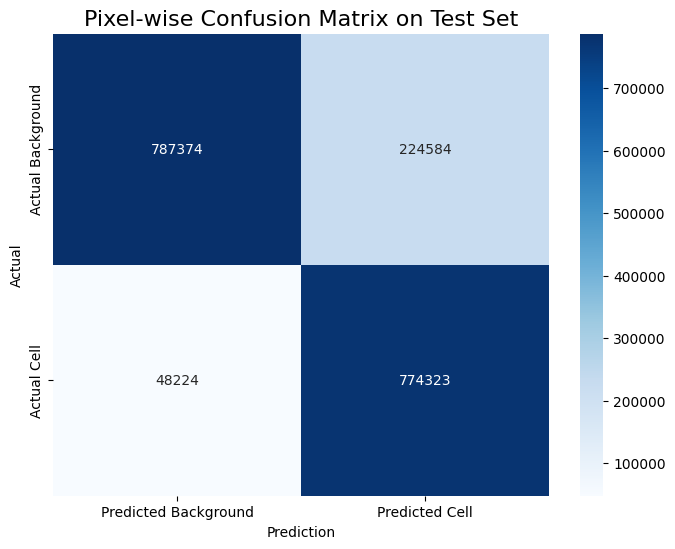

In [ ]:
SECTION 1: SETUP AND INSTALLATIONS
# 1.1: Install Libraries
print("Installing libraries...")
!pip install torch torchvision --quiet
!pip install timm --quiet
!pip install natsort --quiet
!pip install scikit-image --quiet
!pip install opencv-python-headless --quiet
!pip install tqdm --quiet
!pip install seaborn --quiet
print("Installations complete.")

# 1.2: Import Libraries and Set Up Device
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from natsort import natsorted
from tqdm.notebook import tqdm
import os
import cv2
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
import timm
import seaborn as sns
from google.colab import drive

# 1.3: Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

# 1.4: Set up device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# SECTION 2: MODEL DEFINITION (ViT-Huge + Decoder)
# 2.1: Load and Freeze Encoder
vit_model_name = 'vit_huge_patch14_224'
print(f"Loading pre-trained encoder: {vit_model_name}...")
# [cite_start]Note: timm's pretrained=True loads ImageNet weights, a strong starting point [cite: 13346-13348]
encoder = timm.create_model(vit_model_name, pretrained=True, num_classes=0)

print("Freezing encoder weights...")
# Freeze the encoder weights as planned
for param in encoder.parameters():
    param.requires_grad = False
print("Encoder weights frozen.")

# 2.2: Define the Complete Segmentation Model
class ViTSegmentationModel(nn.Module):
    def __init__(self, encoder, input_embed_dim, decoder_start_channels=256):
        """
        Initializes the complete segmentation model.
        Args:
            encoder (nn.Module): The frozen pre-trained ViT encoder.
            input_embed_dim (int): The embedding dimension from the ViT encoder (1280 for ViT-H).
            decoder_start_channels (int): Number of channels for the decoder to start with.
        """
        super().__init__()

        # --- Part A: The Encoder ---
        self.encoder = encoder
        self.input_embed_dim = input_embed_dim

        # --- Part B: The Decoder ---
        # This decoder takes the 16x16 feature map from the ViT-H/14 encoder
        # and upsamples it to the 224x224 target size.

        layers = []
        current_channels = self.input_embed_dim # 1280
        num_upsample_blocks = 4 # 16->32->64->128->256

        for i in range(num_upsample_blocks):
            out_channels = max(decoder_start_channels // (2**i), 32)
            layers.append(nn.ConvTranspose2d(current_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
            layers.append(nn.ReLU())
            current_channels = out_channels

        # Final 1x1 convolution to get to 1 channel (for the mask)
        layers.append(nn.Conv2d(current_channels, 1, kernel_size=1))

        # Bilinear upsampling to force the final size to exactly 224x224
        # This resolves any minor size mismatch (e.g., 256 vs 224)
        layers.append(nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        """
        The full forward pass: Encoder -> Reshape -> Decoder
        """
        # x shape is (B, 3, 224, 224)
        features = self.encoder.forward_features(x)
        # features shape is (B, num_patches + 1, embed_dim), e.g., (B, 257, 1280)

        b, n, c = features.shape

        # Calculate patch grid size (e.g., sqrt(257-1) = 16)
        h = w = int(np.sqrt(n - 1))

        # Reshape for decoder: (B, C, H, W) -> (B, 1280, 16, 16)
        x_decoder = features[:, 1:, :].permute(0, 2, 1).reshape(b, c, h, w)

        # Pass features through the decoder
        output_logits = self.decoder(x_decoder)
        # output_logits shape (B, 1, 224, 224)

        return output_logits

print("ViTSegmentationModel class defined.")


# SECTION 3: DATASET PREPARATION (RPE Dataset)
# 3.1: Function to Generate Pseudo-Ground-Truth Masks [cite: 2662-2677]
def create_masks_and_bboxes(image_path):
    # Read image as grayscale
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None, None

    # Apply Otsu's Thresholding
    _, binary_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply Distance Transform
    distance_transform = ndimage.distance_transform_edt(binary_mask)

    # Find local maxima to act as markers
    coords = peak_local_max(distance_transform, min_distance=7, labels=binary_mask)
    local_maxima_mask = np.zeros(distance_transform.shape, dtype=bool)
    local_maxima_mask[tuple(coords.T)] = True
    markers = ndimage.label(local_maxima_mask)[0]

    # Apply Watershed Algorithm
    instance_mask = watershed(-distance_transform, markers, mask=binary_mask)

    # Get bounding boxes (though we only need the mask for this)
    bounding_boxes = []
    for label in np.unique(instance_mask):
        if label == 0: continue
        coords_mask = np.where(instance_mask == label)
        if coords_mask[0].size > 0:
            y_min, y_max = np.min(coords_mask[0]), np.max(coords_mask[0])
            x_min, x_max = np.min(coords_mask[1]), np.max(coords_mask[1])
            bounding_boxes.append([x_min, y_min, x_max, y_max])

    return instance_mask, bounding_boxes

# 3.2: Segmentation Dataset Class [cite: 2705-2719]
class SegmentationDataset(Dataset):
    def __init__(self, data_paths, transform):
        self.data_paths = data_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        img_path = self.data_paths[idx]

        # Open image and convert to RGB (as required by ViT)
        image = Image.open(img_path).convert("RGB")

        # Generate the pseudo-ground-truth mask
        # We run this every time, but for speed, you could pre-generate and save these
        instance_mask, _ = create_masks_and_bboxes(img_path)
        if instance_mask is None:
            # Handle cases where mask generation failed
            instance_mask = np.zeros(image.size[::-1]) # H, W format

        # Create a binary mask (0 for background, 1 for cells)
        binary_mask = np.where(instance_mask > 0, 1.0, 0.0).astype(np.float32)
        mask = Image.fromarray(binary_mask)

        # Apply transformations
        # Note: We apply transforms *after* mask generation
        image = self.transform(image)

        # Transform mask (resize and convert to tensor)
        mask = transforms.ToTensor()(mask)
        mask = transforms.Resize((224, 224), antialias=True)(mask)

        return image, mask

# 3.3: Define Transforms [cite: 2720-2722]
seg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3.4: Load File Paths
dataset_path_str = "/content/drive/MyDrive/RPE_dataset/Subwindows/" # From your original code
dataset_path = Path(dataset_path_str)

if not dataset_path.exists():
    print(f"ERROR: The directory '{dataset_path_str}' does not exist.")
    print("Please make sure your Google Drive is mounted and the path is correct.")
else:
    all_files = natsorted([f for f in dataset_path.glob("*.tif")])
    print(f"Found {len(all_files)} total images in {dataset_path_str}")

    # For demonstration, let's use a subset (as in your code)
    # You can increase this or use all_files for your full run
    subset_size = 800
    files_to_process = all_files[:subset_size]
    print(f"Working with a subset of {len(files_to_process)} images.")

    # 3.5: Create Full Dataset
    # We create the dataset directly from file paths
    seg_full_dataset = SegmentationDataset(files_to_process, transform=seg_transform)

    # 3.6: Split Dataset (80-10-10 split) [cite: 2724-2727, 8904]
    total_size = len(seg_full_dataset)
    train_size = int(0.8 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    seg_train_dataset, seg_val_dataset, seg_test_dataset = random_split(seg_full_dataset, [train_size, val_size, test_size])
    print(f"Dataset split: Training={len(seg_train_dataset)}, Validation={len(seg_val_dataset)}, Test={len(seg_test_dataset)}")

    # [cite_start]3.7: Create DataLoaders [cite: 2729-2732]
    BATCH_SIZE = 16 # You can adjust this based on Colab GPU memory
    seg_train_loader = DataLoader(seg_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    seg_val_loader = DataLoader(seg_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    seg_test_loader = DataLoader(seg_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    print("DataLoaders created.")


# SECTION 4: TRAIN THE SEGMENTATION MODEL
if 'seg_train_loader' in locals():
    # 4.1: Instantiate the full model
    print("\n--- Initializing Model for Training ---")
    full_model = ViTSegmentationModel(
        encoder=encoder,
        input_embed_dim=encoder.embed_dim  # Get embed_dim from the encoder (e.g., 1280)
    ).to(device)

    #4.2: Define Loss and Optimizer [cite: 2734-2735]
    # BCEWithLogitsLoss is perfect for binary segmentation (cell vs. background)
    criterion = nn.BCEWithLogitsLoss()
    # AdamW is a great default optimizer, especially for transformers
    optimizer = torch.optim.AdamW(full_model.decoder.parameters(), lr=1e-4)
    # 4.3: Training Loop
    num_epochs = 5 # You used 5 in your original code, a good start
    print(f"--- Starting Training for {num_epochs} Epochs ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        full_model.train() # Set model to training mode
        running_loss = 0.0

        progress_bar = tqdm(seg_train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, masks in progress_bar:
            images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = full_model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f"{loss.item():.4f}"})

        avg_train_loss = running_loss / len(seg_train_loader)

        # --- Validation Phase ---
        # This part is new and highly recommended!
        full_model.eval() # Set model to evaluation mode
        val_loss = 0.0

        progress_bar_val = tqdm(seg_val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validate]")
        with torch.no_grad(): # Disable gradient calculation
            for images, masks in progress_bar_val:
                images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)

                outputs = full_model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                progress_bar_val.set_postfix({'val_loss': f"{loss.item():.4f}"})

        avg_val_loss = val_loss / len(seg_val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

    print("--- Segmentation Training Finished ---")
else:
    print("\nSkipping Training and Evaluation as dataset was not loaded.")


# SECTION 5: QUANTITATIVE EVALUATION (ON TEST SET)
if 'full_model' in locals() and 'seg_test_loader' in locals():
    print("\n--- Starting Evaluation on Test Set ---")

    # 5.1: Function to Calculate Pixel-Level Metrics [cite: 2772-2795]
    def calculate_pixel_metrics(loader, model, device):
        model.eval()
        total_tp, total_fp, total_tn, total_fn = 0, 0, 0, 0
        with torch.no_grad():
            for images, masks in tqdm(loader, desc="Calculating Pixel Metrics on Test Set"):
                images, masks = images.to(device), masks.to(device)

                # Get model prediction logits
                outputs = model(images)
                # Convert logits to probabilities (sigmoid) and then to binary predictions (threshold at 0.5)
                preds = torch.sigmoid(outputs) > 0.5

                # Calculate metrics for the batch
                total_tp += ((preds == 1) & (masks == 1)).sum().item()
                total_fp += ((preds == 1) & (masks == 0)).sum().item()
                total_tn += ((preds == 0) & (masks == 0)).sum().item()
                total_fn += ((preds == 0) & (masks == 1)).sum().item()

        return total_tp, total_fp, total_tn, total_fn

    # 5.2: Calculate Metrics [cite: 2797-2808]
    tp, fp, tn, fn = calculate_pixel_metrics(seg_test_loader, full_model, device)

    epsilon = 1e-6 # To avoid division by zero
    iou = tp / (tp + fp + fn + epsilon)
    dice = (2 * tp) / (2 * tp + fp + fn + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)

    # 5.3: Display Final Evaluation Results [cite: 2810-2826]
    print("\n" + "="*50)
    print(" " * 10 + "FINAL EVALUATION RESULTS (ON TEST SET)")
    print("="*50)
    print(f"SEGMENTATION MODEL PERFORMANCE (Pixel-Level):")
    print("-" * 50)
    print(f"  - Intersection over Union (IoU): {iou:.4f}")
    print(f"  - Dice Coefficient:              {dice:.4f}")
    print(f"  - Accuracy:                      {accuracy:.4f}")
    print(f"  - Precision:                     {precision:.4f}")
    print(f"  - Recall (Sensitivity):          {recall:.4f}")
    print("="*50)

    # Plotting the confusion matrix
    conf_matrix = np.array([[tn, fp], [fn, tp]])
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Background', 'Predicted Cell'],
                yticklabels=['Actual Background', 'Actual Cell'])
    plt.title('Pixel-wise Confusion Matrix on Test Set', fontsize=16)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

else:
    print("\nSkipping final evaluation as model or data was not loaded.")

--- Starting Qualitative Visualization ---


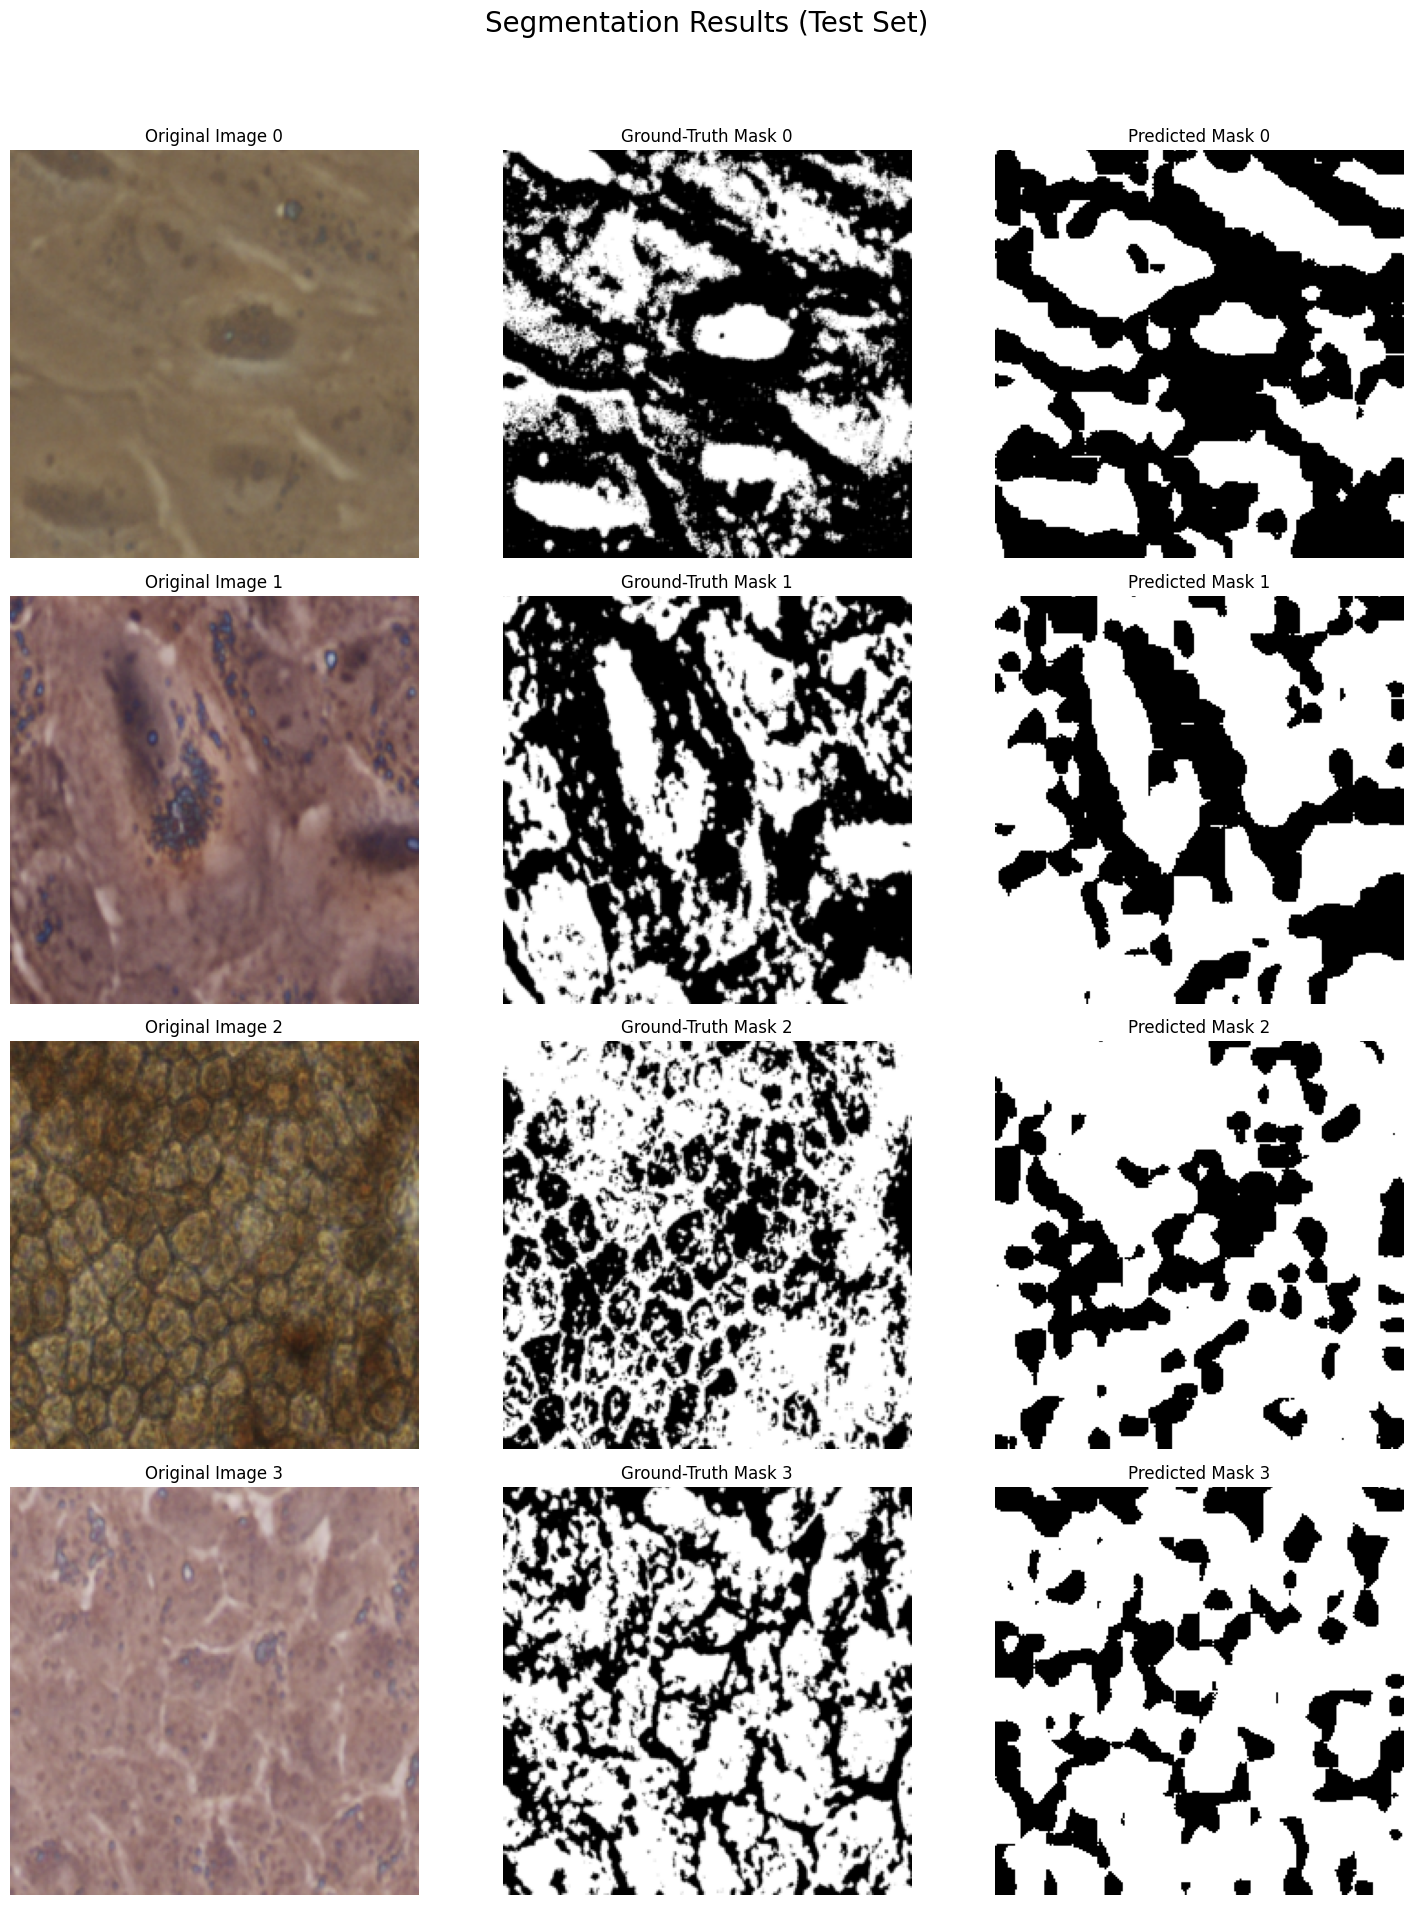

In [ ]:
#SECTION 6: QUALITATIVE VISUALIZATION (ON TEST SET)

print("--- Starting Qualitative Visualization ---")

# 6.1: Set model to evaluation mode
full_model.eval()

# 6.2: Define inverse normalization function for viewing images
# These are the standard ImageNet stats you used for training
def inverse_normalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Reverses the normalization on a tensor to make it viewable."""
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1) # Clamp values to be between 0 and 1

# 6.3: Get one batch of data from the test loader
try:
    images, masks = next(iter(seg_test_loader))
    images, masks = images.to(device), masks.to(device)

    # 6.4: Get model predictions
    with torch.no_grad():
        output_logits = full_model(images)
        # Convert logits -> probabilities -> binary mask
        pred_masks = (torch.sigmoid(output_logits) > 0.5).cpu()

    # Move images and ground-truth masks to CPU for plotting
    images_cpu = images.cpu()
    masks_cpu = masks.cpu()

    # 6.5: Plot the results
    num_to_show = 4 # Show the first 4 images from the batch
    fig, axs = plt.subplots(num_to_show, 3, figsize=(15, num_to_show * 5))
    fig.suptitle("Segmentation Results (Test Set)", fontsize=20)

    for i in range(num_to_show):
        # --- Original Image ---
        ax = axs[i, 0]
        img_tensor = inverse_normalize(images_cpu[i])
        img_to_show = img_tensor.permute(1, 2, 0).numpy() # (C, H, W) -> (H, W, C)
        ax.imshow(img_to_show)
        ax.set_title(f"Original Image {i}")
        ax.axis('off')

        # --- Ground-Truth Mask ---
        ax = axs[i, 1]
        mask_to_show = masks_cpu[i].squeeze().numpy() # (1, H, W) -> (H, W)
        ax.imshow(mask_to_show, cmap='gray')
        ax.set_title(f"Ground-Truth Mask {i}")
        ax.axis('off')

        # --- Predicted Mask ---
        ax = axs[i, 2]
        pred_to_show = pred_masks[i].squeeze().numpy() # (1, H, W) -> (H, W)
        ax.imshow(pred_to_show, cmap='gray')
        ax.set_title(f"Predicted Mask {i}")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

except StopIteration:
    print("Test loader is empty. Cannot visualize results.")
except NameError as e:
    print(f"Error: {e}. Was the model trained and the test loader created?")